In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary

#vital params

 
model_name="ResNet152_stn1"

dataset_name="caltech101"

#hyperparameters
batch_size=10
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: ResNet152_stn1 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch': 5

In [2]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        self.localization = nn.Sequential(
            #nn.Conv2d(3, 8, kernel_size=7),
            nn.Conv2d(3,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            
            
            #nn.Conv2d(8, 10, kernel_size=5),
            nn.Conv2d(8,10, kernel_size = 3),
            nn.Conv2d(10,10,kernel_size = 3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        
    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)

        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
                
    def forward(self, x):
        self.stn(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)



def ResNet50(img_channel=3, num_classes=num_classes):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=num_classes):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=num_classes):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    net = ResNet101(img_channel=3, num_classes=num_classes)
    y = net(torch.randn(4, 3, 224, 224)).to(device)
    print(y.size())


test()

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


torch.Size([4, 101])


In [4]:
model=ResNet152(img_channel=3, num_classes=num_classes).to(device)

#pretesting model for shape
x=torch.randn(batch_size,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, 224, 224)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

torch.Size([10, 3, 224, 224])
torch.Size([10, 101])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
            Conv2d-2          [-1, 8, 220, 220]             584
            Conv2d-3          [-1, 8, 218, 218]             584
         MaxPool2d-4          [-1, 8, 109, 109]               0
              ReLU-5          [-1, 8, 109, 109]               0
            Conv2d-6         [-1, 10, 107, 107]             730
            Conv2d-7         [-1, 10, 105, 105]             910
         MaxPool2d-8           [-1, 10, 52, 52]               0
              ReLU-9           [-1, 10, 52, 52]               0
           Linear-10                   [-1, 32]         865,312
             ReLU-11                   [-1, 32]               0
           Linear-12                    [-1, 6]             198
           Conv2d-13         [-1,

In [5]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [6]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//ResNet152_stn120211229102233
grandstore_string
grandstore/caltech101_ResNet152_stn120211229102233.pkl


In [7]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [8]:
TOP_ACCURACY_TRACK = 10
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=350,
                    minepoch=200,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 22.250
Training Loss: 8796522.6629 	Validation Loss: 4678.7534

Running epoch: 2


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 22.333
Training Loss: 7727698.5376 	Validation Loss: 4666.1301

Running epoch: 3


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 14.167
Training Loss: 7519786.0449 	Validation Loss: 5306.4347

Running epoch: 4


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 17.333
Training Loss: 7120971.9155 	Validation Loss: 4879.1130

Running epoch: 5


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 28.583
Training Loss: 6590010.9839 	Validation Loss: 8340.4266

Running epoch: 6


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 33.000
Training Loss: 6422975.0905 	Validation Loss: 5606.7596

Running epoch: 7


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 24.417
Training Loss: 5853181.5965 	Validation Loss: 19185.8371

Running epoch: 8


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 37.000
Training Loss: 5743210.5398 	Validation Loss: 13614.5081

Running epoch: 9


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 40.167
Training Loss: 5276818.9796 	Validation Loss: 4247.5228

Running epoch: 10


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 44.000
Training Loss: 4747496.7898 	Validation Loss: 4507.9992

Running epoch: 11


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 47.917
Training Loss: 4478584.3913 	Validation Loss: 2790.6931

Running epoch: 12


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 51.833
Training Loss: 3984251.0954 	Validation Loss: 2514.6560

Running epoch: 13


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 46.500
Training Loss: 3623958.5460 	Validation Loss: 20584.6856

Running epoch: 14


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 54.667
Training Loss: 3154633.4662 	Validation Loss: 6887.9924

Running epoch: 15


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 55.000
Training Loss: 2805915.7175 	Validation Loss: 15816.1703

Running epoch: 16


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 34.167
Training Loss: 2461237.3057 	Validation Loss: 198275.4790

Running epoch: 17


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 48.667
Training Loss: 2885611.5073 	Validation Loss: 14110.6087

Running epoch: 18


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.667
Training Loss: 2426725.6380 	Validation Loss: 1969.9311

Running epoch: 19


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.833
Training Loss: 2307383.5553 	Validation Loss: 3056.6109

Running epoch: 20


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.917
Training Loss: 1980488.2983 	Validation Loss: 3206.4207

Running epoch: 21


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.167
Training Loss: 1729965.5776 	Validation Loss: 2947.7433

Running epoch: 22


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.417
Training Loss: 1421549.3468 	Validation Loss: 2674.9965

Running epoch: 23


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 1561901.9570 	Validation Loss: 2417.0915

Running epoch: 24


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 1065624.7804 	Validation Loss: 1753.1910

Running epoch: 25


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.833
Training Loss: 830633.1777 	Validation Loss: 2561.3421

Running epoch: 26


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 658152.7863 	Validation Loss: 2016.3571

Running epoch: 27


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 491545.5313 	Validation Loss: 1806.0021

Running epoch: 28


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 463365.8813 	Validation Loss: 2172.6910

Running epoch: 29


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 404441.2865 	Validation Loss: 1898.6478

Running epoch: 30


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 355491.7646 	Validation Loss: 2147.1760

Running epoch: 31


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.167
Training Loss: 346362.5883 	Validation Loss: 1984.6080

Running epoch: 32


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 321723.5486 	Validation Loss: 2290.6538

Running epoch: 33


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 236968.9654 	Validation Loss: 2235.3661

Running epoch: 34


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 235195.0868 	Validation Loss: 2254.4862

Running epoch: 35


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 245498.8678 	Validation Loss: 2260.7441

Running epoch: 36


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 231346.9605 	Validation Loss: 2261.7254

Running epoch: 37


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 155473.2161 	Validation Loss: 2091.0771

Running epoch: 38


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 181854.0322 	Validation Loss: 2376.3717

Running epoch: 39


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 56.500
Training Loss: 174962.9931 	Validation Loss: 18726.0335

Running epoch: 40


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 305533.8296 	Validation Loss: 3837.4379

Running epoch: 41


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 152236.8402 	Validation Loss: 2662.3347

Running epoch: 42


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.500
Training Loss: 114191.9821 	Validation Loss: 3702.4931

Running epoch: 43


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 174078.2078 	Validation Loss: 1989.3544

Running epoch: 44


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 118326.0182 	Validation Loss: 2503.8638

Running epoch: 45


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.500
Training Loss: 185834.6364 	Validation Loss: 2120.5065

Running epoch: 46


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.667
Training Loss: 126977.0200 	Validation Loss: 5145.4989

Running epoch: 47


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.833
Training Loss: 64089.3225 	Validation Loss: 6581.8467

Running epoch: 48


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 231632.6041 	Validation Loss: 2530.8929

Running epoch: 49


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 57.833
Training Loss: 102395.2998 	Validation Loss: 11355.4741

Running epoch: 50


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 103566.1603 	Validation Loss: 2308.3424

Running epoch: 51


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.917
Training Loss: 52410.0617 	Validation Loss: 3010.7219

Running epoch: 52


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.167
Training Loss: 119254.9891 	Validation Loss: 4287.1899

Running epoch: 53


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 77886.4839 	Validation Loss: 3231.4046

Running epoch: 54


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 114233.3252 	Validation Loss: 2371.2762

Running epoch: 55


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 88778.9426 	Validation Loss: 2494.8146

Running epoch: 56


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 51.083
Training Loss: 87743.1393 	Validation Loss: 287743.3949

Running epoch: 57


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 56884.2670 	Validation Loss: 2065.7828

Running epoch: 58


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 103715.6996 	Validation Loss: 6064.4308

Running epoch: 59


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 61.917
Training Loss: 121494.1394 	Validation Loss: 10940.9846

Running epoch: 60


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.917
Training Loss: 90987.8036 	Validation Loss: 5019.9864

Running epoch: 61


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 61631.1680 	Validation Loss: 12854.4613

Running epoch: 62


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.417
Training Loss: 99834.0515 	Validation Loss: 62744.6102

Running epoch: 63


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.500
Training Loss: 104972.3566 	Validation Loss: 39736.3215

Running epoch: 64


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 45303.2686 	Validation Loss: 16280.8518

Running epoch: 65


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.250
Training Loss: 57909.1147 	Validation Loss: 4976.6972

Running epoch: 66


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 57.417
Training Loss: 53241.7837 	Validation Loss: 119483.9586

Running epoch: 67


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 82458.3991 	Validation Loss: 40042.7777

Running epoch: 68


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 50028.1687 	Validation Loss: 24674.4639

Running epoch: 69


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 72110.1461 	Validation Loss: 9018.1650

Running epoch: 70


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 60.667
Training Loss: 37861.9732 	Validation Loss: 42538.6313

Running epoch: 71


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.167
Training Loss: 101251.6842 	Validation Loss: 11176.3205

Running epoch: 72


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 59.000
Training Loss: 33299.5037 	Validation Loss: 18988.0053

Running epoch: 73


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 86860.0833 	Validation Loss: 23890.5139

Running epoch: 74


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 32262.7032 	Validation Loss: 2579.1972

Running epoch: 75


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 91235.9968 	Validation Loss: 2247.8336

Running epoch: 76


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.333
Training Loss: 64594.7780 	Validation Loss: 13366.1412

Running epoch: 77


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 35966.1739 	Validation Loss: 2175.8151

Running epoch: 78


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.333
Training Loss: 66480.8989 	Validation Loss: 27805.0391

Running epoch: 79


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 43182.3113 	Validation Loss: 6951.8882

Running epoch: 80


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 47558.3385 	Validation Loss: 71622.9874

Running epoch: 81


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 68801.2653 	Validation Loss: 21358.8382

Running epoch: 82


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.333
Training Loss: 111567.9806 	Validation Loss: 24746.5441

Running epoch: 83


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 129477.2273 	Validation Loss: 46179.9646

Running epoch: 84


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 31927.8369 	Validation Loss: 37988.2924

Running epoch: 85


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 25278.7817 	Validation Loss: 18997.6924

Running epoch: 86


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.333
Training Loss: 38716.2214 	Validation Loss: 16065.6751

Running epoch: 87


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.500
Training Loss: 60604.7095 	Validation Loss: 24053.6985

Running epoch: 88


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 45509.5695 	Validation Loss: 24042.5163

Running epoch: 89


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 40042.8260 	Validation Loss: 81599.6075

Running epoch: 90


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 59134.8464 	Validation Loss: 39023.9743

Running epoch: 91


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 96365.9490 	Validation Loss: 2200.6382

Running epoch: 92


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 37252.1078 	Validation Loss: 14924.8797

Running epoch: 93


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 14262.8838 	Validation Loss: 50226.0141

Running epoch: 94


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 37895.4364 	Validation Loss: 8772.1004

Running epoch: 95


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 43652.2488 	Validation Loss: 3457.6121

Running epoch: 96


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 23266.3358 	Validation Loss: 4805.7178

Running epoch: 97


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 47766.3319 	Validation Loss: 7498.3782

Running epoch: 98


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.417
Training Loss: 54536.8275 	Validation Loss: 11540.1065

Running epoch: 99


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 19005.9992 	Validation Loss: 8047.7382

Running epoch: 100


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 61.333
Training Loss: 35670.2009 	Validation Loss: 16254.8201

Running epoch: 101


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 17921.4292 	Validation Loss: 10040.5379

Running epoch: 102


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 34351.7662 	Validation Loss: 5216.8146

Running epoch: 103


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 24939.9450 	Validation Loss: 6643.1691

Running epoch: 104


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 77518.1821 	Validation Loss: 4729.9143

Running epoch: 105


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 57.667
Training Loss: 43357.5582 	Validation Loss: 89781.7438

Running epoch: 106


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 61.833
Training Loss: 22934.9383 	Validation Loss: 21886.0105

Running epoch: 107


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 13719.3114 	Validation Loss: 2491.2218

Running epoch: 108


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 70699.5243 	Validation Loss: 39631.6396

Running epoch: 109


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 70685.7945 	Validation Loss: 6900.8070

Running epoch: 110


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 29970.0066 	Validation Loss: 10403.5514

Running epoch: 111


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 34520.9156 	Validation Loss: 11578.7254

Running epoch: 112


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.750
Training Loss: 47183.6534 	Validation Loss: 13839.7148

Running epoch: 113


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.167
Training Loss: 14471.5961 	Validation Loss: 26960.2288

Running epoch: 114


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 26376.0574 	Validation Loss: 2699.7114

Running epoch: 115


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 13098.0600 	Validation Loss: 4008.3123

Running epoch: 116


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 52.083
Training Loss: 10561.2087 	Validation Loss: 53651.4723

Running epoch: 117


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 58877.4870 	Validation Loss: 11925.8077

Running epoch: 118


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.250
Training Loss: 15841.6438 	Validation Loss: 8390.5273

Running epoch: 119


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 58.250
Training Loss: 44909.8330 	Validation Loss: 428478.3331

Running epoch: 120


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 59998.9213 	Validation Loss: 16115.7168

Running epoch: 121


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 54.583
Training Loss: 28930.1682 	Validation Loss: 1885623.1356

Running epoch: 122


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 58.417
Training Loss: 19444.4030 	Validation Loss: 298866.1278

Running epoch: 123


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 32912.6579 	Validation Loss: 22220.0183

Running epoch: 124


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 52.500
Training Loss: 15104.1341 	Validation Loss: 388996.5251

Running epoch: 125


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 61.417
Training Loss: 40368.8775 	Validation Loss: 102165.7210

Running epoch: 126


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 59.333
Training Loss: 10276.3119 	Validation Loss: 80447.0879

Running epoch: 127


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 60.250
Training Loss: 6563.7531 	Validation Loss: 137396.3846

Running epoch: 128


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 55.167
Training Loss: 12936.2660 	Validation Loss: 401675.3444

Running epoch: 129


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 57.750
Training Loss: 70155.9628 	Validation Loss: 269244.2840

Running epoch: 130


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 55.750
Training Loss: 11658.9469 	Validation Loss: 1236615.3425

Running epoch: 131


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 37384.0018 	Validation Loss: 7224.9326

Running epoch: 132


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 17591.0379 	Validation Loss: 11076.3613

Running epoch: 133


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 43840.5768 	Validation Loss: 9448.0972

Running epoch: 134


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 16237.8115 	Validation Loss: 29009.5867

Running epoch: 135


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 17767.7519 	Validation Loss: 11896.5084

Running epoch: 136


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 40666.1989 	Validation Loss: 140427.1077

Running epoch: 137


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 40248.8035 	Validation Loss: 465481.1204

Running epoch: 138


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.667
Training Loss: 15948.5275 	Validation Loss: 857383.0487

Running epoch: 139


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 7511.0603 	Validation Loss: 411260.2671

Running epoch: 140


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 2497.2285 	Validation Loss: 217015.0054

Running epoch: 141


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 2335.0284 	Validation Loss: 516843.9814

Running epoch: 142


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.417
Training Loss: 39259.7609 	Validation Loss: 74595.4977

Running epoch: 143


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 39062.8737 	Validation Loss: 179375.7076

Running epoch: 144


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.833
Training Loss: 18693.1660 	Validation Loss: 216203.7227

Running epoch: 145


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 8824.6347 	Validation Loss: 57592.7960

Running epoch: 146


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 11362.2047 	Validation Loss: 361623.0599

Running epoch: 147


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 5282.1643 	Validation Loss: 127676.5186

Running epoch: 148


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.083
Training Loss: 59068.9837 	Validation Loss: 1950389.5688

Running epoch: 149


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 35789.4433 	Validation Loss: 536168.9349

Running epoch: 150


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 8353.0868 	Validation Loss: 1421706.4803

Running epoch: 151


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 58.917
Training Loss: 9771.0830 	Validation Loss: 1624497306.6772

Running epoch: 152


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 46190.1056 	Validation Loss: 1023022.8992

Running epoch: 153


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.417
Training Loss: 22089.8602 	Validation Loss: 770225.7795

Running epoch: 154


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 16319.8823 	Validation Loss: 825519.7219

Running epoch: 155


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.417
Training Loss: 5115.1958 	Validation Loss: 677731.0818

Running epoch: 156


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.083
Training Loss: 34023.0107 	Validation Loss: 740521.9720

Running epoch: 157


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 15458.0728 	Validation Loss: 197617.3337

Running epoch: 158


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 13410.4527 	Validation Loss: 1102948.3673

Running epoch: 159


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 3273.4065 	Validation Loss: 226929.8654

Running epoch: 160


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 37025.5972 	Validation Loss: 61902.8011

Running epoch: 161


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 33957.4139 	Validation Loss: 3783.7658

Running epoch: 162


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 8399.6816 	Validation Loss: 8513.2570

Running epoch: 163


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 3972.8222 	Validation Loss: 7660.7241

Running epoch: 164


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.167
Training Loss: 3233.4043 	Validation Loss: 9430.8957

Running epoch: 165


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 3283.4234 	Validation Loss: 7430.7465

Running epoch: 166


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 73281.5178 	Validation Loss: 10456.6881

Running epoch: 167


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 12100.4904 	Validation Loss: 11502.9506

Running epoch: 168


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 12971.8212 	Validation Loss: 4599.9969

Running epoch: 169


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 25130.7981 	Validation Loss: 106701.0638

Running epoch: 170


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 21640.2808 	Validation Loss: 49811.9601

Running epoch: 171


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 11127.7172 	Validation Loss: 83780.9735

Running epoch: 172


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 4177.8904 	Validation Loss: 54661.7277

Running epoch: 173


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 39510.1133 	Validation Loss: 8771.3074

Running epoch: 174


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 57.667
Training Loss: 11987.0162 	Validation Loss: 380377.8584

Running epoch: 175


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 28702.9328 	Validation Loss: 5630.1934

Running epoch: 176


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 7631.1608 	Validation Loss: 5775.7154

Running epoch: 177


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 5438.9017 	Validation Loss: 33146.8081

Running epoch: 178


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 2446.4755 	Validation Loss: 13429.9580

Running epoch: 179


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 5594.5902 	Validation Loss: 4783.6440

Running epoch: 180


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 104755.5677 	Validation Loss: 7837.7594

Running epoch: 181


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 16220.9864 	Validation Loss: 6288.0230

Running epoch: 182


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 8180.0059 	Validation Loss: 6367.1822

Running epoch: 183


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 4036.9796 	Validation Loss: 2369.8368

Running epoch: 184


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 35070.0720 	Validation Loss: 3724.6672

Running epoch: 185


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 13636.2841 	Validation Loss: 24515.7454

Running epoch: 186


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 11726.5412 	Validation Loss: 42862.1391

Running epoch: 187


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.500
Training Loss: 31704.3649 	Validation Loss: 5151.9061

Running epoch: 188


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 19430.4824 	Validation Loss: 4932.6019

Running epoch: 189


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 4476.5381 	Validation Loss: 25952.2345

Running epoch: 190


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 6044.7373 	Validation Loss: 4211.4893

Running epoch: 191


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 29934.1279 	Validation Loss: 4938.3037

Running epoch: 192


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 21199.9517 	Validation Loss: 5118.6655

Running epoch: 193


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 9337.1101 	Validation Loss: 12818.8622

Running epoch: 194


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 25954.7740 	Validation Loss: 5290.1092

Running epoch: 195


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 38874.4364 	Validation Loss: 10620.7310

Running epoch: 196


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 8458.4317 	Validation Loss: 5330.9605

Running epoch: 197


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 11749.2879 	Validation Loss: 3447.9449

Running epoch: 198


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 6112.4125 	Validation Loss: 3657.6453

Running epoch: 199


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 58635.8254 	Validation Loss: 10879.4476

Running epoch: 200


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 4976.3727 	Validation Loss: 172706.9968

Running epoch: 201


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.583
Training Loss: 3230.6803 	Validation Loss: 230092.0890

Running epoch: 202


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 4332.3335 	Validation Loss: 7536.4441

Running epoch: 203


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 8406.3169 	Validation Loss: 38316.8377

Running epoch: 204


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 51909.8948 	Validation Loss: 15269.5201

Running epoch: 205


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.500
Training Loss: 29204.8064 	Validation Loss: 16760.7639

Running epoch: 206


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 8859.3525 	Validation Loss: 7564.1491

Running epoch: 207


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 9880.3045 	Validation Loss: 46899.0815

Running epoch: 208


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 11493.0148 	Validation Loss: 4457.3962

Running epoch: 209


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 22213.3831 	Validation Loss: 24171.1640

Running epoch: 210


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 19738.3097 	Validation Loss: 20046.0287

Running epoch: 211


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 6580.8994 	Validation Loss: 15540.7438

Running epoch: 212


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 24436.9561 	Validation Loss: 18052.0430

Running epoch: 213


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 14633.7172 	Validation Loss: 7094.5112

Running epoch: 214


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 14415.6779 	Validation Loss: 29083.3456

Running epoch: 215


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 8656.0923 	Validation Loss: 8952.8953

Running epoch: 216


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 2507.0460 	Validation Loss: 37660.6708

Running epoch: 217


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 17952.2112 	Validation Loss: 6313.2104

Running epoch: 218


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 29632.9155 	Validation Loss: 2362.2819

Running epoch: 219


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 13217.7444 	Validation Loss: 2776.9634

Running epoch: 220


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 19136.9023 	Validation Loss: 2344.8142

Running epoch: 221


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 8025.9771 	Validation Loss: 3267.6411

Running epoch: 222


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.000
Training Loss: 16342.4242 	Validation Loss: 2472.7039

Running epoch: 223


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 16500.4551 	Validation Loss: 12560.4196

Running epoch: 224


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 20834.2688 	Validation Loss: 33906.6845

Running epoch: 225


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 6677.1766 	Validation Loss: 7526.9331

Running epoch: 226


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 6294.4027 	Validation Loss: 46641.6049

Running epoch: 227


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.167
Training Loss: 9719.4480 	Validation Loss: 6788.0991

Running epoch: 228


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 39199.1360 	Validation Loss: 3424.6364

Running epoch: 229


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 9927.5315 	Validation Loss: 2744.5211

Running epoch: 230


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 14817.5700 	Validation Loss: 2790.2056

Running epoch: 231


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 24926.2491 	Validation Loss: 3279.4779

Running epoch: 232


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 17042.1583 	Validation Loss: 4230.3491

Running epoch: 233


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 3982.4131 	Validation Loss: 2337.9311

Running epoch: 234


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 3500.4091 	Validation Loss: 2441.3562

Running epoch: 235


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 2711.2558 	Validation Loss: 3261.8551

Running epoch: 236


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 59.417
Training Loss: 16949.7354 	Validation Loss: 63179.3281

Running epoch: 237


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 33688.2957 	Validation Loss: 2449.5151

Running epoch: 238


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 4546.4579 	Validation Loss: 7415.2792

Running epoch: 239


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 2509.3374 	Validation Loss: 2245.8188

Running epoch: 240


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 8964.1663 	Validation Loss: 3066.8686

Running epoch: 241


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 21363.9698 	Validation Loss: 4971.2460

Running epoch: 242


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 13045.1712 	Validation Loss: 3641.1246

Running epoch: 243


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 16356.0860 	Validation Loss: 2964.0760

Running epoch: 244


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 4016.1656 	Validation Loss: 11563.2851

Running epoch: 245


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 2858.2617 	Validation Loss: 3746.1514

Running epoch: 246


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 44704.6316 	Validation Loss: 2864.2668

Running epoch: 247


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 9016.4778 	Validation Loss: 3542.8091

Running epoch: 248


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 7597.5839 	Validation Loss: 4322.7182

Running epoch: 249


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 2426.1203 	Validation Loss: 4875.1097

Running epoch: 250


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 1726.6285 	Validation Loss: 8767.8402

Running epoch: 251


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 18837.3611 	Validation Loss: 3183.0898

Running epoch: 252


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 32088.3108 	Validation Loss: 5219.1982

Running epoch: 253


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 11326.7703 	Validation Loss: 5615.6169

Running epoch: 254


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 4680.0092 	Validation Loss: 10731.0931

Running epoch: 255


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 4431.7477 	Validation Loss: 2591.0115

Running epoch: 256


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 20361.0717 	Validation Loss: 2663.3683

Running epoch: 257


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.500
Training Loss: 16764.8726 	Validation Loss: 5151.1346

Running epoch: 258


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 5307.5645 	Validation Loss: 9703.4311

Running epoch: 259


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 7467.6462 	Validation Loss: 5178.1478

Running epoch: 260


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 32615.7605 	Validation Loss: 3568.1564

Running epoch: 261


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 6922.8267 	Validation Loss: 3348.1979

Running epoch: 262


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 7096.2366 	Validation Loss: 4529.0373

Running epoch: 263


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 4577.2945 	Validation Loss: 2440.3710

Running epoch: 264


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 3720.5220 	Validation Loss: 3136.7969

Running epoch: 265


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 2364.8170 	Validation Loss: 5901.9491

Running epoch: 266


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 2020.2844 	Validation Loss: 3947.2062

Running epoch: 267


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 21058.5117 	Validation Loss: 3820.3659

Running epoch: 268


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 22400.5879 	Validation Loss: 3204.3953

Running epoch: 269


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 7671.0286 	Validation Loss: 2581.1235

Running epoch: 270


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 7015.3832 	Validation Loss: 3473.3619

Running epoch: 271


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 2458.1943 	Validation Loss: 3707.2185

Running epoch: 272


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 915.8535 	Validation Loss: 2957.0399

Running epoch: 273


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 2791.0859 	Validation Loss: 2738.0901

Running epoch: 274


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 1621.0672 	Validation Loss: 2840.5878

Running epoch: 275


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 75250.4574 	Validation Loss: 3068.6161

Running epoch: 276


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 11333.1627 	Validation Loss: 2679.7514

Running epoch: 277


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 4068.3962 	Validation Loss: 3976.5617

Running epoch: 278


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 1654.5760 	Validation Loss: 2865.0863

Running epoch: 279


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 3536.2892 	Validation Loss: 2707.4153

Running epoch: 280


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 4121.6677 	Validation Loss: 2748.0591

Running epoch: 281


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 1862.1898 	Validation Loss: 2587.3154

Running epoch: 282


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 16057.9545 	Validation Loss: 2836.0509

Running epoch: 283


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 13165.3774 	Validation Loss: 2816.9955

Running epoch: 284


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 17796.0789 	Validation Loss: 3576.3739

Running epoch: 285


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 3583.9545 	Validation Loss: 2639.5260

Running epoch: 286


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 1911.2080 	Validation Loss: 3097.1855

Running epoch: 287


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 2758.6653 	Validation Loss: 6393.4542

Running epoch: 288


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 18901.3504 	Validation Loss: 2786.5653

Running epoch: 289


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 24707.8496 	Validation Loss: 2842.1950

Running epoch: 290


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.000
Training Loss: 11873.3048 	Validation Loss: 2671.5206

Running epoch: 291


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 7669.6023 	Validation Loss: 2918.6651

Running epoch: 292


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 7517.1688 	Validation Loss: 8291.4916

Running epoch: 293


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 11599.1745 	Validation Loss: 3511.7172

Running epoch: 294


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.000
Training Loss: 7067.2236 	Validation Loss: 2672.8381

Running epoch: 295


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 15331.5556 	Validation Loss: 3047.3146

Running epoch: 296


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 4199.9091 	Validation Loss: 2763.1483

Running epoch: 297


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 13076.8445 	Validation Loss: 2572.3595

Running epoch: 298


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 7093.4674 	Validation Loss: 2666.8604

Running epoch: 299


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.750
Training Loss: 5689.9678 	Validation Loss: 2985.3688

Running epoch: 300


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 33422.0820 	Validation Loss: 2694.4714

Running epoch: 301


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 5790.1163 	Validation Loss: 2746.9512

Running epoch: 302


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 10996.8707 	Validation Loss: 2877.6669

Running epoch: 303


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 6426.7567 	Validation Loss: 2666.6823

Running epoch: 304


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.000
Training Loss: 22925.3464 	Validation Loss: 2775.2077

Running epoch: 305


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 6688.1178 	Validation Loss: 2706.1226

Running epoch: 306


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 2182.3631 	Validation Loss: 2534.8147

Running epoch: 307


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 3567.3560 	Validation Loss: 2496.1637

Running epoch: 308


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 1926.0416 	Validation Loss: 2728.7568

Running epoch: 309


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 28524.2933 	Validation Loss: 3325.7333

Running epoch: 310


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 31528.0201 	Validation Loss: 2994.4264

Running epoch: 311


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 12983.6786 	Validation Loss: 3374.5233

Running epoch: 312


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 3071.5803 	Validation Loss: 3350.4344

Running epoch: 313


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 3431.4182 	Validation Loss: 3002.0205

Running epoch: 314


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 2329.5376 	Validation Loss: 3529.8381

Running epoch: 315


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 6192.5631 	Validation Loss: 2866.0248

Running epoch: 316


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 30252.9741 	Validation Loss: 2835.7618

Running epoch: 317


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 6978.7730 	Validation Loss: 2599.2302

Running epoch: 318


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 10430.1127 	Validation Loss: 5375.6770

Running epoch: 319


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 11106.0427 	Validation Loss: 2562.2969

Running epoch: 320


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 10101.7335 	Validation Loss: 7515.4120

Running epoch: 321


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 6229.0562 	Validation Loss: 2719.7963

Running epoch: 322


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 18097.3936 	Validation Loss: 2561.7940

Running epoch: 323


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 4087.0193 	Validation Loss: 5298.5065

Running epoch: 324


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 3076.6685 	Validation Loss: 2590.6709

Running epoch: 325


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 10872.1984 	Validation Loss: 2818.8543

Running epoch: 326


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 15708.2075 	Validation Loss: 6857.5693

Running epoch: 327


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 5181.0156 	Validation Loss: 3092.8534

Running epoch: 328


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 9597.0069 	Validation Loss: 2816.3511

Running epoch: 329


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 12245.9789 	Validation Loss: 4310.4566

Running epoch: 330


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 5016.7438 	Validation Loss: 8214.5990

Running epoch: 331


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 3052.3596 	Validation Loss: 5034.5069

Running epoch: 332


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 1855.0723 	Validation Loss: 2771.2295

Running epoch: 333


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 2760.4245 	Validation Loss: 5614.8808

Running epoch: 334


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 11451.4422 	Validation Loss: 4259.6594

Running epoch: 335


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 15372.2909 	Validation Loss: 3611.2069

Running epoch: 336


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 60.583
Training Loss: 10160.2969 	Validation Loss: 77804.7481

Running epoch: 337


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 4074.7370 	Validation Loss: 10769.2945

Running epoch: 338


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 3498.2777 	Validation Loss: 3229.2916

Running epoch: 339


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 2783.2416 	Validation Loss: 12412.0788

Running epoch: 340


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 1229.3350 	Validation Loss: 6535.2920

Running epoch: 341


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 2571.5357 	Validation Loss: 4550.3487

Running epoch: 342


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 2571.8643 	Validation Loss: 3135.9960

Running epoch: 343


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 6503.0108 	Validation Loss: 9321.3703

Running epoch: 344


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 61559.7907 	Validation Loss: 80122.4354

Running epoch: 345


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 10587.1323 	Validation Loss: 133422.3973

Running epoch: 346


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 6958.8454 	Validation Loss: 155214.1607

Running epoch: 347


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 8851.2271 	Validation Loss: 15451.0784

Running epoch: 348


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 4885.8939 	Validation Loss: 3075.8884

Running epoch: 349


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 2947.8189 	Validation Loss: 2713.8301

Running epoch: 350


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 2437.2857 	Validation Loss: 2557.6367



Model of: ResNet152_stn1 running on: caltech101

Total Run 350 epoch(s)
Accuracy MIN: 14.166666666666666 / MAX: 75.66666666666667

Top 10 performing epochs:
#1 epoch 272	||train_acc 75.67%	||test 73.00%
#2 epoch 273	||train_acc 75.08%	||test 72.58%
#3 epoch 307	||train_acc 74.92%	||test 72.75%
#4 epoch 306	||train_acc 74.92%	||test 71.08%
#5 epoch 271	||train_acc 74.75%	||test 71.42%
#6 epoch 270	||train_acc 74.75%	||test 71.00%
#7 epoch 264	||train_acc 74.67%	||test 71.17%
#8 epoch 308	||train_acc 74.50%	||test 70.67%
#9 epoch 305	||train_acc 74.33%	||test 70.67%
#10 epoch 233	||train_acc 74.25%	||test 72.17%

Last epoch:
epoch 350	||train_acc 73.92%	||test 71.92%

The model has parameters: 59219299


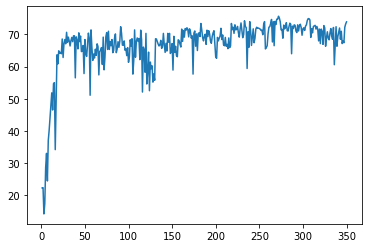

In [9]:
print("Model of: "+model_name +
      " running on: "+dataset_name+"\n")

print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [10]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)